<a href="https://colab.research.google.com/github/ROYMASON11v1/CompuBlanda/blob/main/Proyecto_Final/Reconocimiento_imagen_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Bienvenido**

Para utilizar el modelo debera descargar y montar el siguiente archivo a los datos locales de Colab.

https://drive.google.com/file/d/1KIof1vBrzcBaGQBrqx1IYxoPwkkAmndw/view?usp=sharing

Luego, ejecute la seccion "Index".
Tenga presente que en la sub seccion "Configuracion", se le pedira el cargue de dos archivos.

En primer lugar, la imagen del objeto que desea buscar.
Despues, el video sobre el cual desea realizar la busqueda.

**La seccion red neuronal NO debe ser ejecutado a menos que se realicen cambios en el modelo**

##**Red neuronal CNN con keras y tensor**

* https://pharos.sh/reconocimiento-de-imagenes-en-python-con-tensorflow-y-keras/

* https://pythonistaplanet.com/cifar-10-image-classification-using-keras/

* https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

# Set random seed for purposes of reproducibility
seed = 21


In [ ]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
# one hot encode outputs
Objects = ["Aeroplane", 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Ship', 'Horse', 'Truck']
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
#class_num = len(Objects)
class_num = y_test.shape[1]

In [ ]:
model = Sequential()

#La primera capa de nuestro modelo es una capa convolucional. Tomará las entradas y ejecutará filtros convolucionales en ellas.
#32 es el numero de filtros necesarios
#un filtro es una matriz de valores numerios. En este caso el tamño del filtro es (3,3)

#La imagen de entrada tiene 32*32*3, es decir:
# 32 de altura, 32 de acho y el 3 restante se refiere a los valores RGB
#Acada uno de los numeros de esta matriz se le dan valores de 0 a 255

#El resultado de esta capa seran algunos mapas de entidades, en el cual se muestran algunas caracteristicas especificas de la imagen.
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
#Utilizamos la funcion de activacion ReLu.
#ReLu reemplaza todos los valores de pixeles negativos en el mapa por 0.
model.add(Activation('relu'))

#Ahora agregaremos una capa de deserción para evitar el sobreajuste, que funciona eliminando aleatoriamente algunas de las conexiones entre las capas
model.add(Dropout(0.2))#0.2 significa que elimina el 20% de las conexiones existentes

#Creamos una capa de normalizacion por lotes
#Al normalizar las entradas que se dirigen a la siguiente capa, aseguramos que la red siempre cree activaciones con la misma distribucion que deseamos.
model.add(BatchNormalization())

#Ahora Creamos otra capa convolucional, pero el tamaño del filtro aumenta para que la red pueda aprender representaciones más complejas
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

#Creamos una capa de agrupacion que ayudara a que el clasificador sea mas robusto para que pueda aprender patrones relevantes.
model.add(MaxPooling2D(pool_size=(2, 2)))
#Agregamos la desercion
model.add(Dropout(0.2))
#Agregamos la normalizacion por lotes
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


#Flatten es usado para convertir el mapa de entidades a 1 dimencsion.
model.add(Flatten())
model.add(Dropout(0.2))

#Ahora creamos una capa densamente conectada.
#Es necesario espeficipar el numero de neuronas en la capa densa, recordar que en la siguientes capas este numero tendra que disminuir ...
#... acercandose finalmente el mismo numero de neuronas que clases hay en el conjunto de datos.

#La restriccion de kernal ayuda a regularizar los datos a medida que prender, por lo que se previene el sobreajuste.
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
  
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#En esta ultima capa densamente conectada pasamos el numero de clases por el numero de neuronas. Cada neurona representa una clase, ...
#... y la salida de esta capa sera un vector de 10 neuronas con cada neurona almacenando alguna probabilidad de que la imagen en cuestion ...
#   ... pertenezca a la clase que representa.
model.add(Dense(class_num))

#Utilizamos la funcion de activacion softmax.
#softmax toma como entrada un vector de k numeros y lo normaliza en una ...
#.... distribucion de probabilidad que consiste en k probabilidades propocionales a los exponenciales de los numeros de entrada.
model.add(Activation('softmax')) 

In [ ]:
#Numero de epocas para las que queremos entrenar
epochs = 30

#El optimizador es lo que ajustara los pesos en su red para acercase al punto de menor perdida.
lrate = 0.01 
decay = lrate/epochs 
sgd = SGD(learning_rate=lrate, momentum=0.5, decay=decay, nesterov=False)

In [ ]:
#Compilamos el modelo con los parametros elegidos.
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
#Podemos imprimir el resumen del modelo
#print(model.summary())

In [ ]:
numpy.random.seed(seed)
#Realizamos el entrenamiento del modelo
#Entrenaremos con 50000 muestras y validaremos con 10000 sacadas de cifar10
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

In [ ]:
# Model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:

from keras.models import model_from_json
import numpy as np

# serialize model to JSON
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/model.h5")
print("Saved model to disk")

#**Index**

##**Inicializar Drive**

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('/content')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1hhhdROS0AvUzpnLLGbNNqo7P3u-5srWv' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


title: model.h5, id: 1dwjK2mmfOe-N3dZkEzzTLP7FLErB4lvf
downloading to /content/model.h5
title: model.json, id: 1dXfYh76X778nzVmJDSWyV4JN8gamSTJU
downloading to /content/model.json


##**Main**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
import numpy as np 
from keras.preprocessing import image
from keras.models import model_from_json

In [ ]:
# load json and create model
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#loaded_model.summary()

Loaded model from disk


In [ ]:
#Objetos posibles
Objects = ["Avion", 'Automovil', 'Pajaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Barco', 'Caballo', 'Camion']
#Direccion
path = '/content/'

In [ ]:
def ObjectImage(PathIMG):
  test_image1 =image.load_img(path + PathIMG,target_size =(32,32))
  test_image =image.img_to_array(test_image1) 

  test_image = test_image/255.0

  test_image =np.expand_dims(test_image, axis =0)

  result = loaded_model.predict(test_image)

  ObjectPosible = -1

  for i in range(10):
    if i == 0 or result[0][i] > result[0][ObjectPosible]:
      ObjectPosible = i
    
  print("Se detecto un "+Objects[ObjectPosible]+'\n')
  return ObjectPosible

In [ ]:
def ExtractFrames(PathVideo):

  capture =cv2.VideoCapture(path + PathVideo)
  contFrame = 0
  PerSecond = 0
  
  while (capture.isOpened()):
    
    PerSecond = capture.get(cv2.CAP_PROP_FPS)
    ret, frame = capture.read()

    if (ret == True):
      cv2.imwrite(path + 'IMG_%04d.jpg' % contFrame, frame)
      contFrame += 1
      if (cv2.waitKey(1) == ord('s')):
        break
    else:
      break

  capture.release()
  cv2.destroyAllWindows()

  return contFrame, PerSecond

In [ ]:
def FrameObjectComparison(CodeObjectImage, FramePath):
  frame_image1 =image.load_img(path + FramePath,target_size =(32,32))
  frame_image =image.img_to_array(frame_image1) 

  frame_image = frame_image/255.0

  frame_image =np.expand_dims(frame_image, axis =0)

  result = loaded_model.predict(frame_image)

  ObjectPosible = -1

  for i in range(10):
    if i == 0 or result[0][i] > result[0][ObjectPosible]:
      ObjectPosible = i

  return (ObjectPosible == CodeObjectImage)

In [ ]:
def Comparison(ContFrame, CodeObjectImage):
  ObjectPresence = []
  for i in range(ContFrame):
    FramePath = ('IMG_%04d.jpg' % i)

    if FrameObjectComparison(CodeObjectImage, FramePath)==True:
      ObjectPresence.append(i)

  return ObjectPresence

In [ ]:
def PrintFrames(ObjectPresence, PerSecond):
  print('\n')
  for i in ObjectPresence:
    print('Frame at '+ str(i*(1/PerSecond)) +' second.')

    image=cv2.imread(path + ('IMG_%04d.jpg' % i))
    cv2_imshow(image)

    print('\n\n')

In [ ]:
def Config(PathIMG, PathVideo):
  CodeObjectImage = ObjectImage(PathIMG)
  ContFrames, PerSecond = ExtractFrames(PathVideo)
  ObjectPresence = Comparison(ContFrames, CodeObjectImage)

  print('Se encontro un '+Objects[CodeObjectImage]+' en '+str(len(ObjectPresence))+' frames.')
  PrintFrames(ObjectPresence, PerSecond)

##**Configuracion**

In [ ]:
from google.colab import files

Img = files.upload()
Vid = files.upload()

Saving TestImage.jpg to TestImage.jpg


Saving WhatsApp Video 2021-12-01 at 1.52.45 PM.mp4 to WhatsApp Video 2021-12-01 at 1.52.45 PM.mp4


Se detecto un Gato

Se encontro un Gato en 16 frames.


Frame at 16.157704066543438 second.


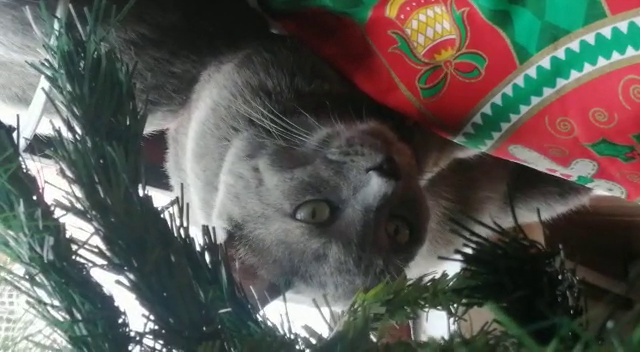




Frame at 16.492232101047442 second.


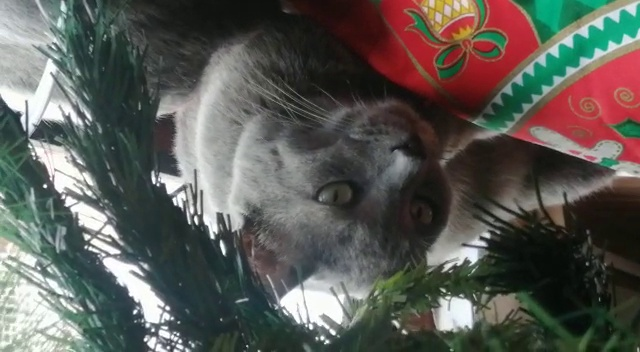




Frame at 16.525684904497844 second.


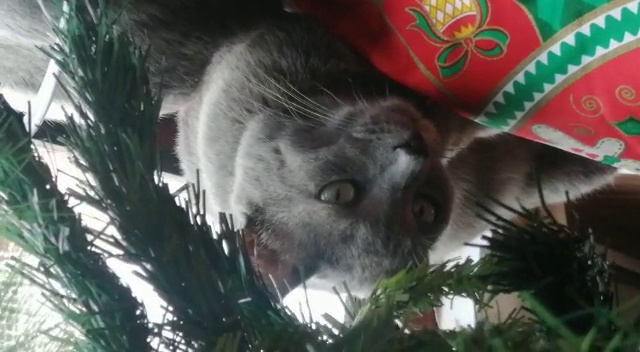




Frame at 16.592590511398644 second.


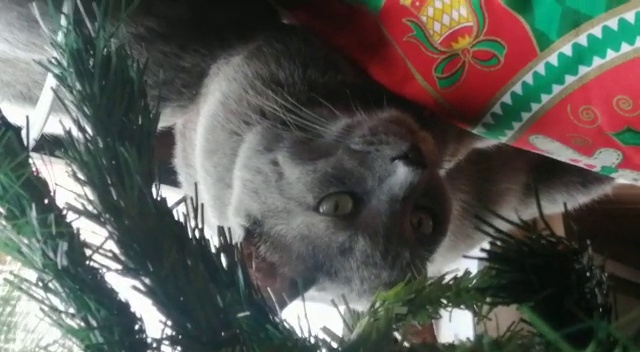




Frame at 16.826760135551446 second.


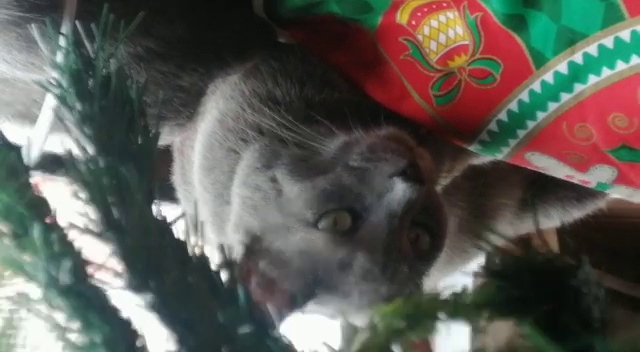




Frame at 16.860212939001848 second.


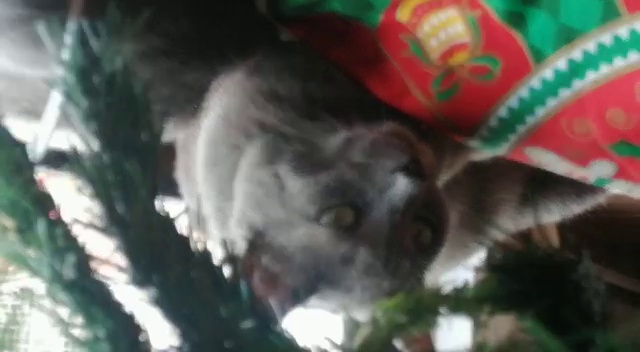




Frame at 16.89366574245225 second.


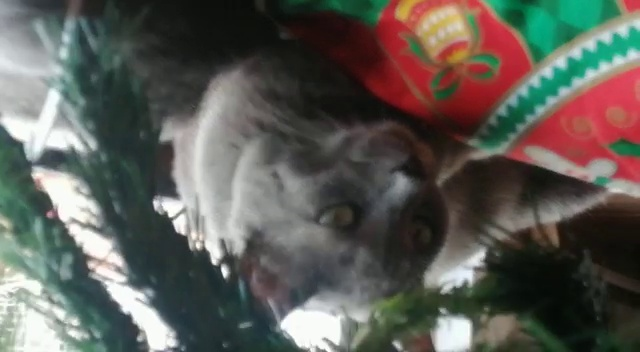




Frame at 16.927118545902648 second.


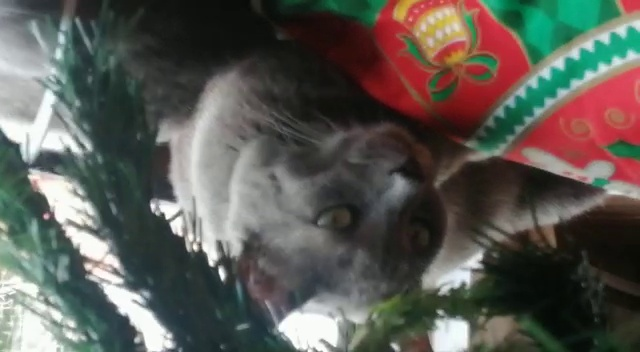




Frame at 16.96057134935305 second.


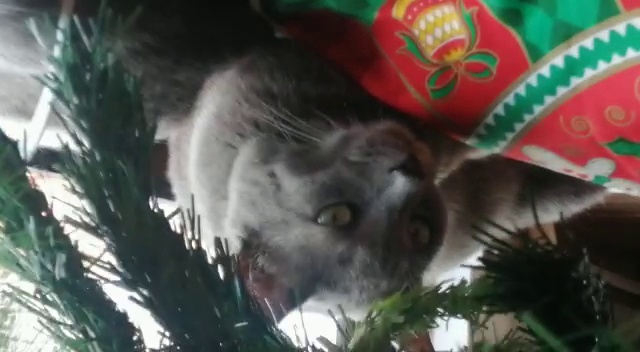




Frame at 17.02747695625385 second.


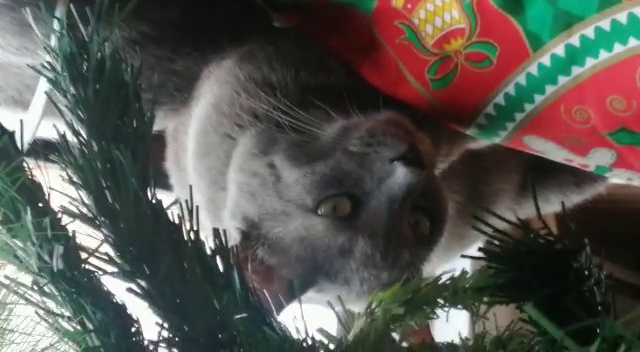




Frame at 17.06092975970425 second.


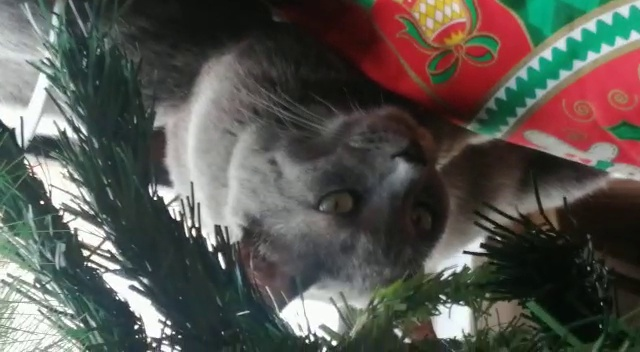




Frame at 17.09438256315465 second.


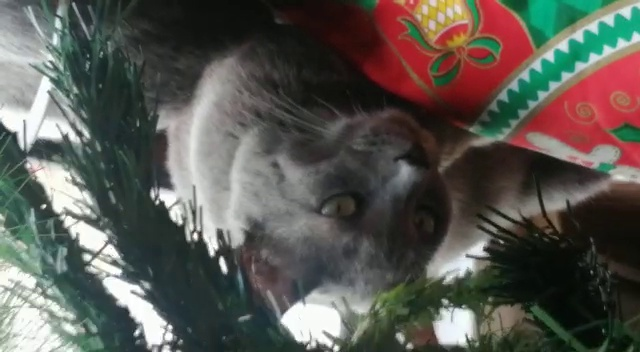




Frame at 17.161288170055453 second.


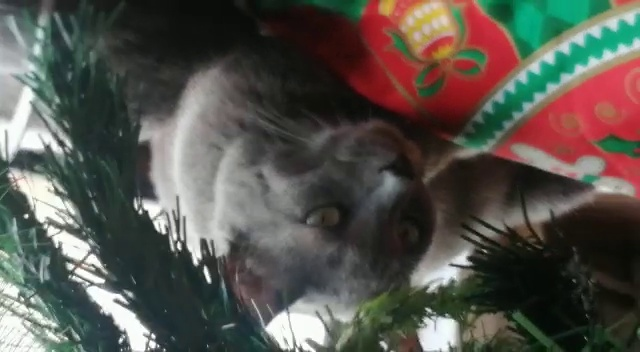




Frame at 17.19474097350585 second.


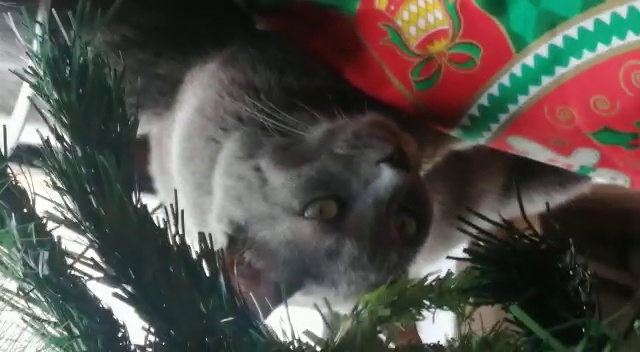




Frame at 17.295099383857053 second.


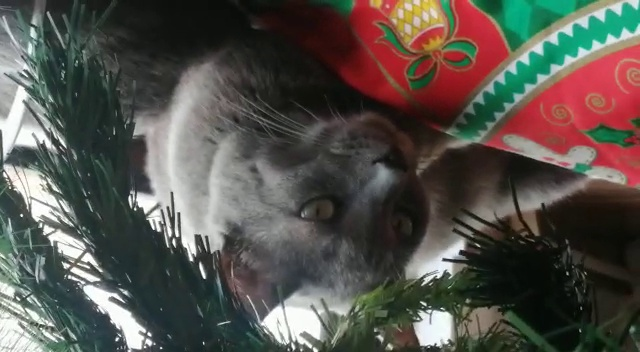




Frame at 17.69653302526186 second.


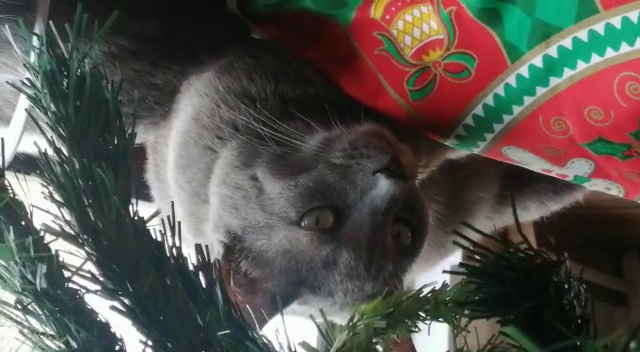

In [ ]:
nameImg = None
namevideo = None
for fn in Img.keys():
  nameImg = fn

for fn in Vid.keys():
  namevideo = fn

PathIMG = nameImg
PathVideo = namevideo

Config(PathIMG, PathVideo)